<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Reading-a-netcdf-file" data-toc-modified-id="Reading-a-netcdf-file-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Reading a netcdf file</a></span></li></ul></li><li><span><a href="#Calculate-the-temperature-and-vapor-fluxes" data-toc-modified-id="Calculate-the-temperature-and-vapor-fluxes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calculate the temperature and vapor fluxes</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#As-expected,-vapor-transport-dominates-the-energy-flux-in-the-warm-marine-boundary-layer" data-toc-modified-id="As-expected,-vapor-transport-dominates-the-energy-flux-in-the-warm-marine-boundary-layer-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>As expected, vapor transport dominates the energy flux in the warm marine boundary layer</a></span></li></ul></li><li><span><a href="#Closer-examination-of-fluxes-at-200-m" data-toc-modified-id="Closer-examination-of-fluxes-at-200-m-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Closer examination of fluxes at 200 m</a></span><ul class="toc-item"><li><span><a href="#now-do-the-same-for-the-turbulent-fluxes-at-that-level-in-W/m^2" data-toc-modified-id="now-do-the-same-for-the-turbulent-fluxes-at-that-level-in-W/m^2-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>now do the same for the turbulent fluxes at that level in W/m^2</a></span></li><li><span><a href="#But-there-are-some-gridcells-with-huge-flux-values" data-toc-modified-id="But-there-are-some-gridcells-with-huge-flux-values-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>But there are some gridcells with huge flux values</a></span></li><li><span><a href="#Next:--joint-distributions" data-toc-modified-id="Next:--joint-distributions-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Next:  joint distributions</a></span></li><li><span><a href="#Writing-our-own-histogram-routine" data-toc-modified-id="Writing-our-own-histogram-routine-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Writing our own histogram routine</a></span></li><li><span><a href="#Now-redo-the-wvel,-T-scatterplot-as-a-2-d-histogram,-plotting-log10(counts)" data-toc-modified-id="Now-redo-the-wvel,-T-scatterplot-as-a-2-d-histogram,-plotting-log10(counts)-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Now redo the wvel, T scatterplot as a 2-d histogram, plotting log10(counts)</a></span></li></ul></li></ul></li></ul></div>

# visualizing the cloud field with vapor

In [1]:
from a405.utils.data_read import download
the_root = "http://clouds.eos.ubc.ca/~phil/courses/atsc500/docs"
the_file =  "tropical_clouds.zip"
out=download(the_file,root=the_root)

trying http://clouds.eos.ubc.ca/~phil/courses/atsc500/docs/tropical_clouds.zip
writing to: tropical_clouds.zip
writing temporary file tropical_clouds.zip_tmp
downloaded tropical_clouds.zip
size = 28912275


unzip this and open the vdf file in vapor

## Reading a netcdf file

In [45]:
import urllib.request
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from a500.utils.data_read import download
from a500.thermo.constants import constants as c

In [2]:
download("tropical_subset.nc",
         root="http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical_subset.nc")

trying http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical_subset.nc/tropical_subset.nc
writing to: tropical_subset.nc

tropical_subset.nc already exists
and is 52116281 bytes
will not overwrite



In [3]:
def do_reynolds(array3d):
    """
        do a spatial-mean reynolds average of a 3d field array3d
        needs dimensions arranged as (z,y,x)
        returns avg(z),perturb(z,y,x)
    """
    avg=array3d.mean(axis=2).mean(axis=1)
    perturb=array3d.T - avg
    perturb=perturb.T
    return avg,perturb

In [5]:
with Dataset('tropical_subset.nc','r') as nc_in:
    print(list(nc_in.variables.keys()))
    the_temp=nc_in.variables['TABS'][0,...]  
    #
    # remove the time dimension since we only have one timestep
    #   
    print('temp shape',the_temp.shape)
    the_height=nc_in.variables['z'][...]
    xvals=nc_in.variables['x'][...]
    yvals=nc_in.variables['y'][...]
    print('height shape',the_height.shape)
    the_press=nc_in.variables['p'][...]
    the_press=the_press*100.  #convert to Pa
    wvel=nc_in.variables['W'][0,...]  #m/s
    qv=nc_in.variables['QV'][0,...]  #vapor g/kg
    ql=nc_in.variables['QN'][0,...]  #liquid  g/kg
  

['x', 'y', 'z', 'time', 'p', 'U', 'V', 'W', 'PP', 'TABS', 'QV', 'QN', 'QP']
temp shape (112, 110, 100)
height shape (112,)


# Calculate the temperature and vapor fluxes

In [15]:
Rd=287  #J/kg/K
g2kg = 1.e-3
meter2km = 1.e-3
qv_avg,qv_perturb=do_reynolds(qv)
temp_avg,temp_perturb=do_reynolds(the_temp)
rho_avg=the_press/(Rd*temp_avg)
w_avg,w_perturb = do_reynolds(wvel)
T_flux=((w_perturb*temp_perturb).T*rho_avg).T*c.cpd  #W/m^2
qv_flux=((w_perturb*qv_perturb).T*rho_avg).T*c.lv0*g2kg #W/m^2
T_flux_1d=(T_flux).mean(axis=2).mean(axis=1)
qv_flux_1d=(qv_flux).mean(axis=2).mean(axis=1)

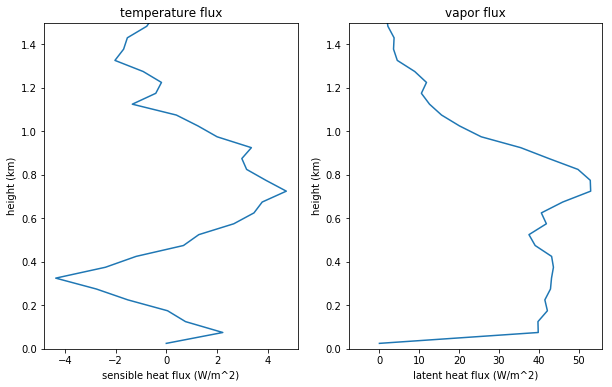

In [16]:
fig,ax=plt.subplots(1,2,figsize=(10,6))
ax[0].plot(T_flux_1d,the_height*meter2km)  
ax[0].set(xlabel='sensible heat flux (W/m^2)',ylabel='height (km)',title='temperature flux')
ax[1].plot(qv_flux_1d,the_height*meter2km)  
out=ax[1].set(xlabel='latent heat flux (W/m^2)',ylabel='height (km)',title='vapor flux')
out=[the_ax.set(ylim=(0,1.5)) for the_ax in ax]

## As expected, vapor transport dominates the energy flux in the warm marine boundary layer

## Closer examination of fluxes at 200 m

1\.  Look at simple histograms at one level

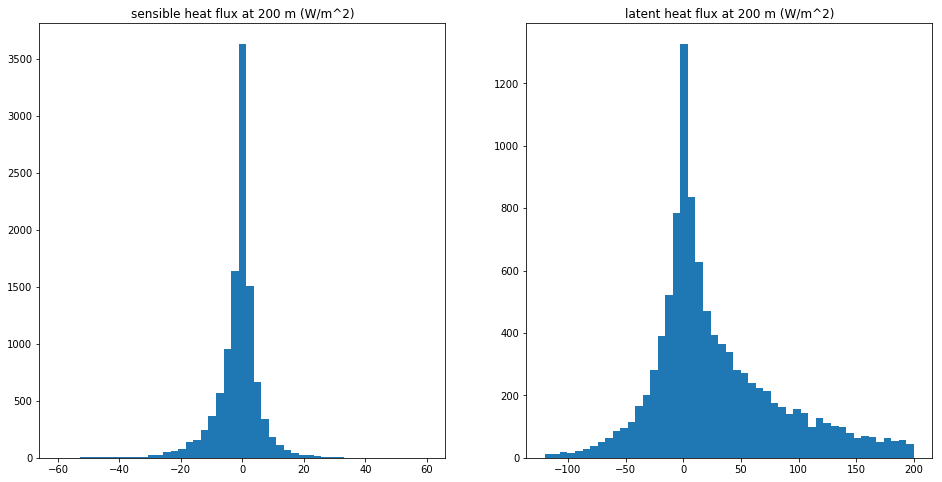

In [19]:
#
# select the level closest to 200 meters
# using searchsorted
#
zlev=np.searchsorted(the_height,200)
ql_800 = ql[zlev,:,:] == 0.
T_flux_800 = T_flux[zlev,:,:] #W/m^2
qv_flux_800 = qv_flux[zlev,:,:] #W/m^2
fig,ax = plt.subplots(1,2,figsize=(16,8))
out=ax[0].hist(T_flux_800.flat,bins=np.linspace(-60,60,50))
out=ax[1].hist(qv_flux_800.flat,bins=np.linspace(-120,200,50))
ax[0].set(title='sensible heat flux at 200 m (W/m^2)')
ax[1].set(title='latent heat flux at 200 m (W/m^2)');

### now do the same for the turbulent fluxes at that level in W/m^2

-1.51637
41.5281


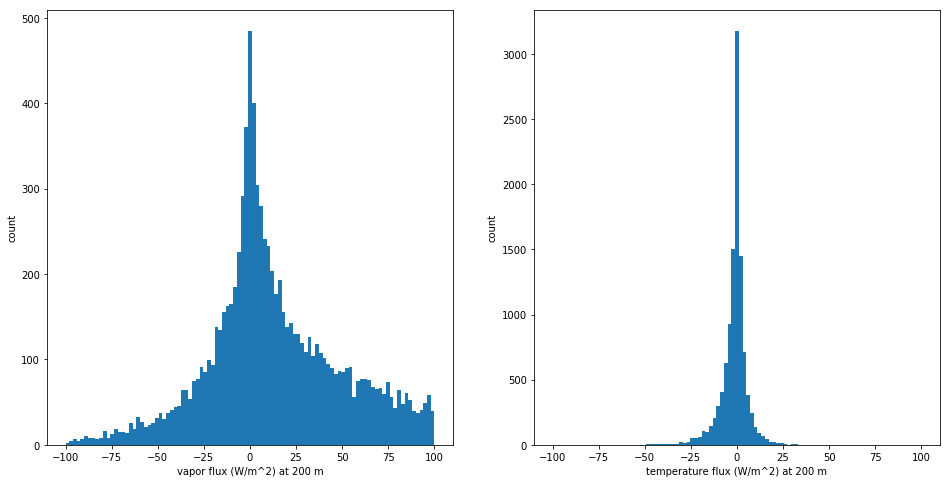

In [22]:
wpert_200=w_perturb[zlev,...]
Tpert_200=temp_perturb[zlev,...]
qvpert_200 = qv_perturb[zlev,...]
T_flux200=((wpert_200*Tpert_200)*rho_avg[zlev])*c.cpd  #W/m^2
qv_flux200=((wpert_200*qvpert_200)*rho_avg[zlev])*c.lv0*g2kg #W/m^2
print(T_flux200.mean())
print(qv_flux200.mean())
fig,ax=plt.subplots(1,2,figsize=(16,8))
out=ax[0].hist(qv_flux200.flat,bins=np.linspace(-100,100,100))
out=ax[1].hist(T_flux200.flat,bins=np.linspace(-100,100,100))
[item.set(ylabel='count') for item in ax]
ax[0].set(xlabel='vapor flux (W/m^2) at 200 m')
ax[1].set(xlabel='temperature flux (W/m^2) at 200 m');



###  But there are some gridcells with huge flux values

Here's what happens when I don't limit the flux ranges

[Text(0,0.5,'sensible heat flux (W m^2)'),
 Text(0.5,0,'latent heat flux (W/m^2)')]

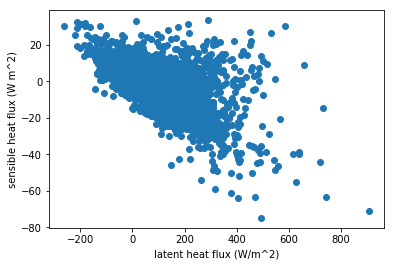

In [23]:
fig,ax=plt.subplots(1,1)
ax.scatter(qv_flux200.flat,T_flux200.flat)
ax.set(xlabel=r'latent heat flux (W/m^2)',
       ylabel=r'sensible heat flux (W m^2)')

### Next:  joint distributions

We'll need to look at correlations between variables. One way to do that is with multi-dimensional histograms.  There is a plotting package called seaborn that can do this
for you:

```python
   conda install seaborn
   
```

Below we use seaborn.jointplot to print a fancy 2d histogram for the joint
distribution of the vapor and temperture fluxes

[Text(27.125,0.5,'temperature flux'), Text(0.5,33,'vapor flux')]

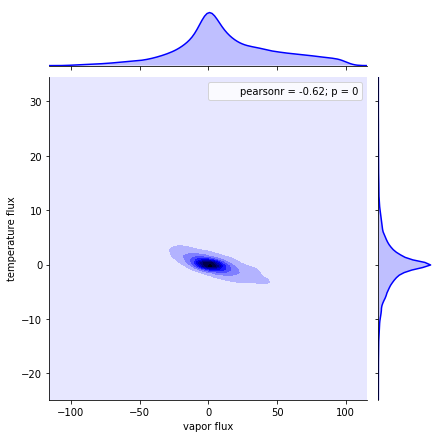

In [25]:
import seaborn as sns
#
#  limit the range f the data to be plotted
#
hit=((qv_flux200 > -100) & (qv_flux200 < 100)) &( (T_flux200 > -50) & (T_flux200 < 50))
g=sns.jointplot(x=qv_flux200[hit].flat,y=T_flux200[hit].flat,kind='kde',color='blue')
ax=g.ax_joint
ax.set(xlabel='vapor flux',ylabel='temperature flux')



For the above plot, note the wider range for the vapor flux, and the negative correlation
between temperature and vapor

### Writing our own histogram routine

There are a lot of cases where it's useful to roll our own histograms.  For example,
here's a $w^\prime$  $T^\prime$ plot with a lot of points

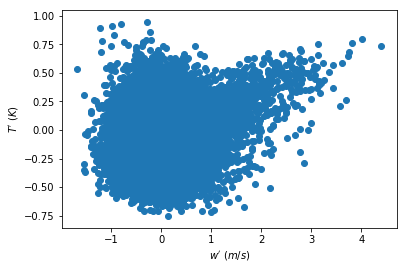

In [32]:
fig,ax=plt.subplots(1,1)
ax.scatter(w_perturb,temp_perturb)
ax.set(xlabel=r'$w^\prime\ (m/s)$',ylabel=r'$T^\prime\ (K)$');

Now histogram this by doing the following using the code (installation covered in class)

pull from github, which will bring in

[hist_numba.py](https://github.com/phaustin/atsc500/blob/master/a500_code/hist_numba.py)

To install this, cd to atsc500 and do:

```python
pip install -e .
```

To make it work, you will also need to do:

```python
conda install numba
```

which installs the numba jit ('just in time') compiler, that can produce code speedups of a factor of several hundred if we stick to a basic subset of 
[python](http://numba.pydata.org/numba-doc/0.21.0/reference/pysupported.html) and 
[numpy](http://numba.pydata.org/numba-doc/0.21.0/reference/numpysupported.html) features.

Numba is used [here](https://github.com/phaustin/atsc500/blob/master/a500_code/hist_numba.py#L6-L38) to speed up the loop that counts the number of datapoints in
each 2-d bin


In [29]:
from a500.utils.hist_numba import hist2d
print(help(hist2d))

Help on function hist2d in module a500.utils.hist_numba:

hist2d(col_raw, row_raw, col_edges, row_edges)
    Produce a 2-d histogram (for example, of temperature (y) vs.
      vertical velocity (x) data)  binned into temperature,wvel
      bins
    input: row_raw,col_raw: data vectors of the row variable (temperature)
           and the column variable (wvel)
           col_edges, row_edges:  coordinates of the bin edges for each variables
    returns:  counts,col_centers,row_centers
    
    Example, given 10,000 temperature measurements to be binned into 20 bins, and
             20,000 wvel measurements to be binned into 10 bins, return
             counts as a [20,10]  array with the number of measurements that fall
             into each bin

None


### Now redo the wvel, T scatterplot as a 2-d histogram, plotting log10(counts)

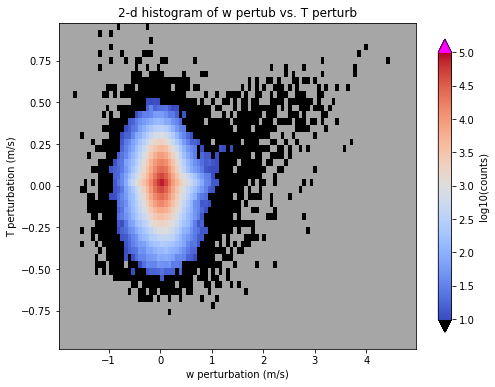

In [31]:
from matplotlib.colors import Normalize

wedges=np.linspace(-2,5,100)
Tedges=np.linspace(-1,1,50)
counts,row_centers,col_centers=hist2d(w_perturb.ravel(), 
                                       temp_perturb.ravel(),wedges,Tedges)
mask=np.isnan(counts)
counts=np.ma.array(counts,mask=mask)
fig,ax=plt.subplots(1,1,figsize=(8,6))
#
# we want to map 256 colors from the coolwarm palette  into the
# data range log10(counts) = 1 to log10(counts) = 5  (i.e. 10 to 100,000)
#
#  we also want to color empty bins grey, and show all bins that aren't empty
#  but fall outside of the range as either black (less than 10 counts) or magenta
#  (more than 100,000) counts
#
cmap=plt.get_cmap('coolwarm')
cmap.set_under('black')
cmap.set_over('magenta')
cmap.set_bad('0.65')
the_norm=Normalize(vmin=1,vmax=5)
cs=ax.pcolormesh(row_centers,col_centers,np.log10(counts),cmap=cmap,norm=the_norm)
ax.set(xlabel='w perturbation (m/s)',ylabel='T perturbation (m/s)',
       title='2-d histogram of w pertub vs. T perturb')
cbar=fig.colorbar(cs,shrink=0.9,extend='both')
cbar.ax.set(ylabel='log10(counts)');

[Text(0.5,1,'latent heat flux at 200 m (W/m^2)')]

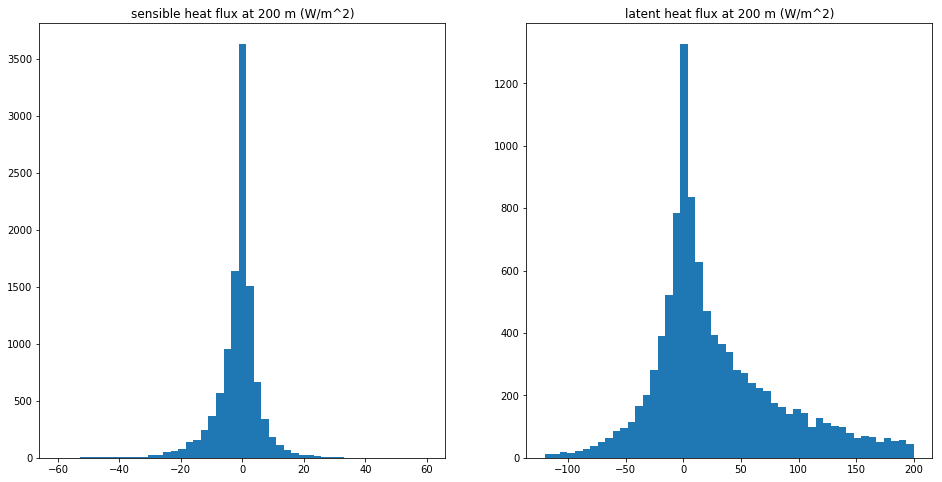

In [33]:
#
# select the level closest to 200 meters
# using searchsorted
#
zlev=np.searchsorted(the_height,200)
ql_200 = ql[zlev,:,:] == 0.
T_flux_200 = T_flux[zlev,:,:] #W/m^2
qv_flux_200 = qv_flux[zlev,:,:] #W/m^2
fig,ax = plt.subplots(1,2,figsize=(16,8))
out=ax[0].hist(T_flux_200.flat,bins=np.linspace(-60,60,50))
out=ax[1].hist(qv_flux_200.flat,bins=np.linspace(-120,200,50))
ax[0].set(title='sensible heat flux at 200 m (W/m^2)')
ax[1].set(title='latent heat flux at 200 m (W/m^2)')

# sensible heat flux much narrower at 200 m than at 800 m
# latent heat flux also right-skewed at 200 m; similar in shape

In [ ]:
# turbulent fluxes at 200 m
wpert_200=w_perturb[zlev,...]
Tpert_200=temp_perturb[zlev,...]
qvpert_200 = qv_perturb[zlev,...]
T_flux200=((wpert_200*Tpert_200)*rho_avg[zlev])*cpd  #W/m^2
qv_flux200=((wpert_200*qvpert_200)*rho_avg[zlev])*lv*g2kg #W/m^2
print(T_flux200.mean())
print(qv_flux200.mean())
fig,ax=plt.subplots(1,2,figsize=(16,8))
out=ax[0].hist(qv_flux200.flat,bins=np.linspace(-100,100,100))
out=ax[1].hist(T_flux200.flat,bins=np.linspace(-100,100,100))
[item.set(ylabel='count') for item in ax]
ax[0].set(xlabel='vapor flux (W/m^2) at 200 m')
ax[1].set(xlabel='temperature flux (W/m^2) at 200 m')

# vapor flux at 200 m is right-skewed as opposed to symmetric
# temperature flux is a lot narrower at 200 m than at 800 m

In [ ]:
fig,ax=plt.subplots(1,1)
ax.scatter(qv_flux200.flat,T_flux200.flat)
ax.set(xlabel=r'latent heat flux (W/m^2)',ylabel=r'sensible heat flux (W m^2)')

# no swoosh at 200 m
# clustered around much smaller fluxes, less than 200; max flux is less than 1000

[Text(27.125,0.5,'temperature flux'), Text(0.5,33,'vapor flux')]

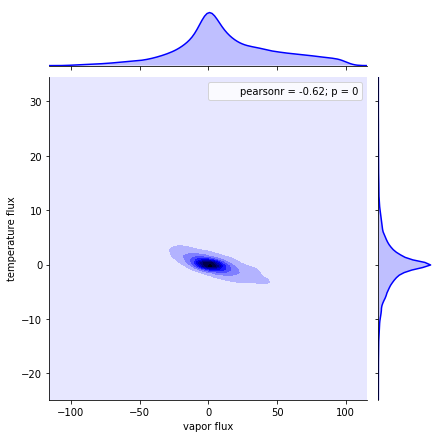

In [38]:
import seaborn as sns
#
#  limit the range f the data to be plotted
#
hit=((qv_flux200 > -100) & (qv_flux200 < 100)) &( (T_flux200 > -50) & (T_flux200 < 50))
g=sns.jointplot(x=qv_flux200[hit].flat,y=T_flux200[hit].flat,kind='kde',color='blue')
ax=g.ax_joint
ax.set(xlabel='vapor flux',ylabel='temperature flux');

# vapor flux is skewed right instead of symmetric
# -0.62 pearsonr instead of -0.83
# narrow temperature distribution
# 2D histogram shows longer tail to the bottom right

[Text(0,0.5,'$T^\\prime\\ (K)$'), Text(0.5,0,'$w^\\prime\\ (m/s)$')]

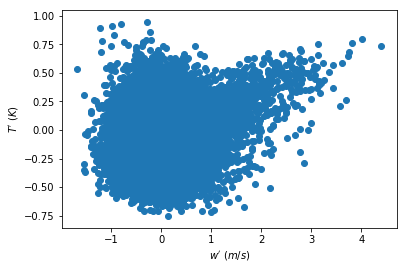

In [39]:
fig,ax=plt.subplots(1,1)
ax.scatter(w_perturb,temp_perturb)
ax.set(xlabel=r'$w^\prime\ (m/s)$',ylabel=r'$T^\prime\ (K)$');

[Text(0,0.5,'log10(counts)')]

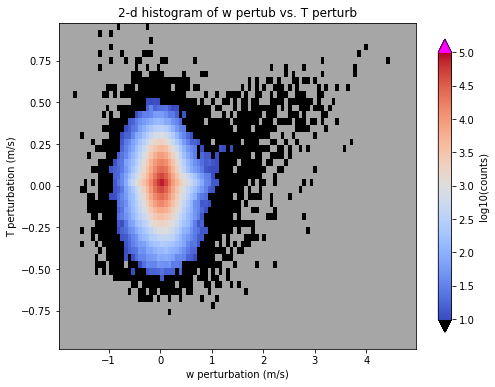

In [40]:
from matplotlib.colors import Normalize

wedges=np.linspace(-2,5,100)
Tedges=np.linspace(-1,1,50)
counts,row_centers,col_centers=hist2d(w_perturb.ravel(), 
                                       temp_perturb.ravel(),wedges,Tedges)
mask=np.isnan(counts)
counts=np.ma.array(counts,mask=mask)
fig,ax=plt.subplots(1,1,figsize=(8,6))
#
# we want to map 256 colors from the coolwarm palette  into the
# data range log10(counts) = 1 to log10(counts) = 5  (i.e. 10 to 100,000)
#
#  we also want to color empty bins grey, and show all bins that aren't empty
#  but fall outside of the range as either black (less than 10 counts) or magenta
#  (more than 100,000) counts
#
cmap=plt.get_cmap('coolwarm')
cmap.set_under('black')
cmap.set_over('magenta')
cmap.set_bad('0.65')
the_norm=Normalize(vmin=1,vmax=5)
cs=ax.pcolormesh(row_centers,col_centers,np.log10(counts),cmap=cmap,norm=the_norm)
ax.set(xlabel='w perturbation (m/s)',ylabel='T perturbation (m/s)',
       title='2-d histogram of w pertub vs. T perturb')
cbar=fig.colorbar(cs,shrink=0.9,extend='both')
cbar.ax.set(ylabel='log10(counts)')

In [ ]:
#
#  Make a color imaged with a scaled colormap
#
from matplotlib.colors import Normalize
#
# also get the cloud liquid water field at the same level
#
ql_200=ql[zlev,:,:]*lv*rho_avg[zlev]  #g/kg
# center the colorbar about 0
#
the_norm=Normalize(vmin=-100,vmax=100)

cmap=plt.get_cmap('coolwarm')
cmap.set_under('black')
cmap.set_over('magenta')
cmap.set_bad('0.75')
fig,ax=plt.subplots(1,2,figsize=(16,8))
cs=ax[0].pcolormesh(xvals*1.e-3,yvals*1.e-3,T_flux_200,cmap=cmap,norm=the_norm)
ax[0].set(ylim=(40,51),xlabel='distance east (km)',ylabel='distance north (km)',
          title='sensible heat flux at 200 m')
cbar=fig.colorbar(cs,shrink=0.9,extend='both')
out=cbar.ax.set(ylabel='T_flux ($W/m^2$)')
out[0].set(rotation=-90,va='bottom')
#
#  hide pixels with no liquid water
#
hit=ql_200 < 1.e-2
T_flux_masked=np.ma.array(T_flux_200,mask=hit)
cs=ax[1].pcolormesh(xvals*1.e-3,yvals*1.e-3,T_flux_masked,cmap=cmap,norm=the_norm)
ax[1].set(ylim=(40,51),title='sensible heat flux in cloud',xlabel='distance east (km)')

# no liquid water at 200 m, so no sensible heat flux in cloud

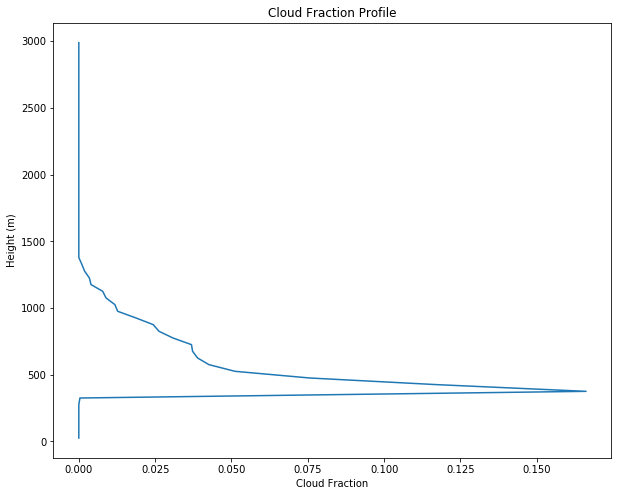

In [44]:
# profile of cloud fraction

# initialize profile array
cloud_fraction_profile = []

# find 3000 m level
max_lev=np.searchsorted(the_height,3000)

# loop through each level, obtain liquid water field, and sum up cloudy pixels
for lev in range(0, max_lev):
    ql_z = ql[lev,:,:]*c.lv0*rho_avg[lev]
    is_cloud_z = [True if pixel > 1e-2 else False for pixel in ql_z.flat] # list comprehension woot!
    
    cloud_fraction_profile.append(np.sum(is_cloud_z)/len(is_cloud_z)) # append cloud fraction to profile

# plot
fig,ax=plt.subplots(1,1,figsize=(10,8))
ax.plot(cloud_fraction_profile,the_height[0:max_lev]) 
ax.set(title='Cloud Fraction Profile', 
       xlabel='Cloud Fraction', ylabel='Height (m)');